## Load data

In [4]:


import numpy as np, pandas as pd
from sklearn.datasets import fetch_openml

Xy = fetch_openml(name="diabetes", version=1,as_frame=True) # Pima (binary)
df = pd.concat([Xy.data, Xy.target.rename("target")], axis=1)

# df["target"] = df["target"].astype(int) # ensure 0/1
# df.head()

# print(df["target"].unique())

df["target"] = df["target"].map({
    "tested_negative": 0,
    "tested_positive": 1
}).astype(int)

df.head()

,preg,plas,pres,skin,insu,mass,pedi,age,target
0,6,148,72,35,0,33.6,0.627,50,1
1,1,85,66,29,0,26.6,0.351,31,0
2,8,183,64,0,0,23.3,0.672,32,1
3,1,89,66,23,94,28.1,0.167,21,0
4,0,137,40,35,168,43.1,2.288,33,1


## Quick EDA

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 768 entries, 0 to 767
Data columns (total 9 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   preg    768 non-null    int64  
 1   plas    768 non-null    int64  
 2   pres    768 non-null    int64  
 3   skin    768 non-null    int64  
 4   insu    768 non-null    int64  
 5   mass    768 non-null    float64
 6   pedi    768 non-null    float64
 7   age     768 non-null    int64  
 8   target  768 non-null    int64  
dtypes: float64(2), int64(7)
memory usage: 54.1 KB


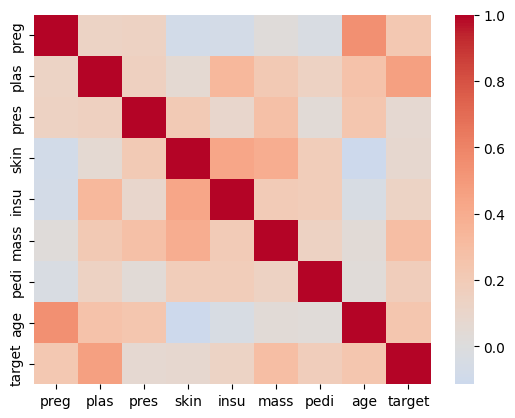

In [7]:
df.info()
df.describe().T
df["target"].value_counts(normalize=True)
import seaborn as sns, matplotlib.pyplot as plt
sns.heatmap(df.corr(numeric_only=True), cmap="coolwarm", center=0)
plt.show()

# Split and baseline

## Train/val/test split, boss

In [10]:
from sklearn.model_selection import train_test_split

X = df.drop(columns=["target"])
y = df["target"]
X_train, X_temp, y_train, y_temp = train_test_split(
    X, y, test_size=0.3, stratify=y, random_state=42
)
X_valid, X_test, y_valid, y_test = train_test_split(
    X_temp, y_temp, test_size=0.5, stratify=y_temp, random_state=42
)

## Baselines:

In [12]:
from sklearn.dummy import DummyClassifier
from sklearn.metrics import roc_auc_score, average_precision_score

def eval_probs(clf, Xv, yv, label):
    p = clf.predict_proba(Xv)[:,1]
    print(f"{label} | ROC-AUC={roc_auc_score(yv, p):.3f} | PR-AUC={average_precision_score(yv, p):.3f}")

dummy = DummyClassifier(strategy="most_frequent").fit(X_train, y_train)
eval_probs(dummy, X_valid, y_valid, "Dummy (most frequent)")

Dummy (most frequent) | ROC-AUC=0.500 | PR-AUC=0.348


# Models and Pipelines

## Pipelines

In [16]:
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler
from sklearn.impute import SimpleImputer
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.pipeline import Pipeline

num_cols = X.columns.tolist()

num_pipe = Pipeline([
    ("impute", SimpleImputer(strategy="median")),
    ("scale", StandardScaler())
])

preproc_linear = ColumnTransformer([
    ("num", num_pipe, num_cols)
])

preproc_tree = ColumnTransformer([
    ("num", SimpleImputer(strategy="median"), num_cols)
])

logit = Pipeline([
    ("prep", preproc_linear),
    ("clf", LogisticRegression(max_iter=200, class_weight="balanced", C=1.0))
])

rf=Pipeline([
    ("prep", preproc_tree),
    ("clf", RandomForestClassifier(
        n_estimators=300, max_depth=None, min_samples_leaf=2, random_state=42, class_weight="balanced_subsample"
    ))
])

for name, model in [("Logistic", logit), ("RandomForest", rf)]:
    model.fit(X_train, y_train)
    eval_probs(model, X_valid, y_valid, name)

Logistic | ROC-AUC=0.830 | PR-AUC=0.709
RandomForest | ROC-AUC=0.833 | PR-AUC=0.696


## Light hyperparameter search debbe

In [18]:
from sklearn.model_selection import GridSearchCV

rf_grid = {
    "clf__n_estimators": [200,400],
    "clf__max_depth": [None, 6, 10],
    "clf__min_samples_leaf": [1,2,4]
}
rf_cv = GridSearchCV(rf, rf_grid, scoring="average_precision", cv=5, n_jobs=-1)
rf_cv.fit(X_train, y_train)
best_rf = rf_cv.best_estimator_
eval_probs(best_rf, X_valid, y_valid, "RF (best)")


RF (best) | ROC-AUC=0.837 | PR-AUC=0.698


# Evaluation and decision threshold

## Pick threshold 𝜏 to hit precision ≥ 0.80 and maximise recall

In [21]:
import numpy as np
from sklearn.metrics import precision_recall_curve

def pick_threshold_for_precision(y_true, prob, min_precision=0.80):
    prec, rec, thr = precision_recall_curve(y_true, prob)

    candidates = [(p,r,t) for p, r,t in zip(prec[:-1], rec[:-1], thr) if p >= min_precision]
    if not candidates:
        # fallback: highest F1
        f1 = 2 * (prec[:-1]*rec[:-1]) / (prec[:-1]+rec[:-1] + 1e-12)
        i = np.argmax(f1)
        return prec[i], rec[i], thr[i]
    # choonse max recall among candidates
    p,r,t = max(candidates, key=lambda x:x[1])
    return p,r,t

def evaluate_with_threshold(model, Xv, yv, label, min_precision=0.80):
    prob = model.predict_proba(Xv)[:,1]
    p, r, t = pick_threshold_for_precision(yv, prob, min_precision)
    from sklearn.metrics import classification_report, confusion_matrix
    yhat = (prob >= t).astype(int)
    print(f"{label} | chosen τ={t:.3f} | precision={p:.3f} | recall={r:.3f}")
    print(confusion_matrix(yv, yhat))
    print(classification_report(yv, yhat, digits=3))
    return t

tau = evaluate_with_threshold(best_rf if 'best_rf' in globals() else rf, X_valid, y_valid, "Selected model", min_precision=0.80)


Selected model | chosen τ=0.763 | precision=0.818 | recall=0.225
[[73  2]
 [31  9]]
              precision    recall  f1-score   support

           0      0.702     0.973     0.816        75
           1      0.818     0.225     0.353        40

    accuracy                          0.713       115
   macro avg      0.760     0.599     0.584       115
weighted avg      0.742     0.713     0.655       115



## Lock the threshold, test one time:

In [24]:
final_model = best_rf if 'best_rf' in globals() else rf
final_model.fit(pd.concat([X_train, X_valid]), pd.concat([y_train, y_valid]))
prob_test = final_model.predict_proba(X_test)[:,1]
yhat_test = (prob_test >= tau).astype(int)

from sklearn.metrics import precision_score, recall_score, f1_score, roc_auc_score, average_precision_score, confusion_matrix
print("Test metrics:")
print("Precision:", precision_score(y_test, yhat_test))
print("Recall:", recall_score(y_test, yhat_test))
print("F1:", f1_score(y_test, yhat_test))
print("ROC-AUC:", roc_auc_score(y_test, prob_test))
print("PR-AUC:", average_precision_score(y_test, prob_test))
print("Confusion matrix:\n", confusion_matrix(y_test, yhat_test))


Test metrics:
Precision: 1.0
Recall: 0.2682926829268293
F1: 0.4230769230769231
ROC-AUC: 0.8621138211382113
PR-AUC: 0.7916457770562394
Confusion matrix:
 [[75  0]
 [30 11]]


# Interpretability and stakeholder summary!
## Premutation importance (model-agnostic):

In [27]:
from sklearn.inspection import permutation_importance

r = permutation_importance(final_model, X_test, y_test, n_repeats=20, random_state=42, scoring="average_precision")
imp = pd.DataFrame({"feature": X.columns, "importance": r.importances_mean}).sort_values("importance", ascending=False)
imp.head(9)

,feature,importance
1,plas,0.211138
5,mass,0.093862
6,pedi,0.027589
7,age,0.019679
4,insu,0.009382
3,skin,0.004343
2,pres,0.002663
0,preg,-0.004079


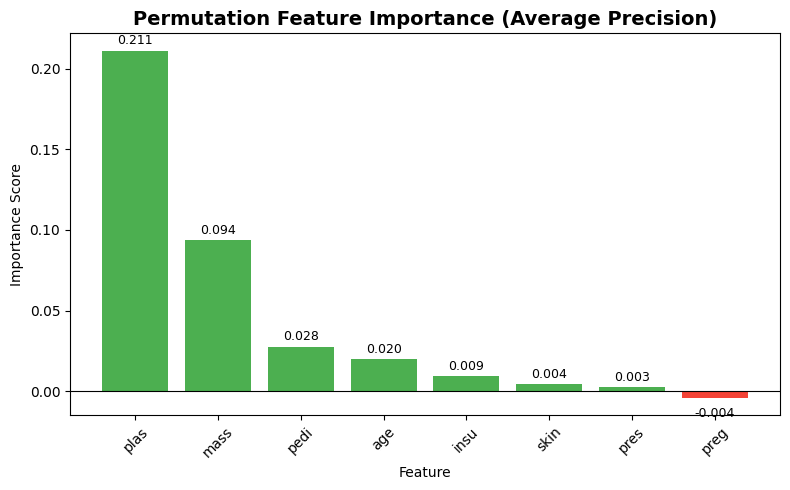

In [29]:
import matplotlib.pyplot as plt

# Your permutation importance calculation
from sklearn.inspection import permutation_importance

r = permutation_importance(
    final_model, 
    X_test, 
    y_test, 
    n_repeats=20, 
    random_state=42, 
    scoring="average_precision"
)

# Create & sort DataFrame
imp = (
    pd.DataFrame({
        "feature": X.columns,
        "importance": r.importances_mean
    })
    .sort_values("importance", ascending=False)
)

# Take top 9 (or however many you want)
imp_top = imp.head(9)

# Plot directly from DataFrame
plt.figure(figsize=(8,5))
bars = plt.bar(
    imp_top["feature"], 
    imp_top["importance"], 
    color=["#4CAF50" if val > 0 else "#F44336" for val in imp_top["importance"]]
)
plt.axhline(0, color='black', linewidth=0.8)
plt.title("Permutation Feature Importance (Average Precision)", fontsize=14, weight='bold')
plt.ylabel("Importance Score")
plt.xlabel("Feature")
plt.xticks(rotation=45)

# Add value labels
for bar, val in zip(bars, imp_top["importance"]):
    plt.text(
        bar.get_x() + bar.get_width()/2, 
        val + (0.002 if val >= 0 else -0.006),
        f"{val:.3f}", 
        ha='center', 
        va='bottom' if val >= 0 else 'top', 
        fontsize=9
    )

plt.tight_layout()
plt.show()
